In [46]:
import os

import clean
import matplotlib.pyplot as plt
import numpy as np

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers

In [47]:
splits = clean.get_space_splits()
i_train, i_tune, i_test, t_train, t_tune, t_test = (
    splits[part] if part.startswith("t") else splits[part][:, 1:].reshape((-1, 10, 4))
    for part in ["i_train", "i_tune", "i_test", "t_train", "t_tune", "t_test"]
)
i_train: np.ndarray

In [48]:
@keras.saving.register_keras_serializable()
class InputNorm(layers.Layer):
    def __init__(self, n_inputs=4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mean = self.add_weight(
            shape=(1, 1, n_inputs),
            initializer="zero",
            trainable=False,
        )
        self.std = self.add_weight(
            shape=(1, 1, n_inputs),
            initializer="zero",
            trainable=False,
        )

    def adapt(self, data: np.ndarray):
        self.mean.assign(np.nanmean(data, axis=(0, 1)).reshape((1, 1, -1)))
        self.std.assign(np.nanstd(data, axis=(0, 1)).reshape((1, 1, -1)))

    def call(self, inp, **kwargs):
        return keras.ops.where(
            keras.ops.isnan(inp),
            0,
            keras.ops.divide(keras.ops.subtract(inp, self.mean), self.std),
        )

In [56]:
keras.utils.set_random_seed(42)

input_norm = InputNorm(name="input_norm")
input_norm.adapt(i_train)
output_denorm = layers.Normalization(
    axis=-1,
    invert=True,
    mean=t_train.mean(axis=0),
    variance=t_train.var(axis=0),
    name="output_denorm",
)

model = keras.Sequential(
    [
        layers.Input((10, 4), batch_size=50),
        input_norm,
        layers.Masking(name="mask"),
        layers.LSTM(4, name="lstm"),
        layers.Dense(1, name="output"),
        output_denorm,
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.losses.MeanAbsolutePercentageError()],
)
model(i_train[:50])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (InputNorm)          │ (50, 10, 4)            │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mask (Masking)                  │ (50, 10, 4)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (50, 4)                │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (50, 1)                │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_denorm (Normalization)   │ (50, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157 (628.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 8 (32.00 B)

In [58]:
keras.utils.set_random_seed(42)

history = model.fit(
    i_train,
    t_train,
    batch_size=500,
    epochs=30,
    validation_data=(i_tune, t_tune),
    # callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True)],
)

Epoch 1/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 455.2359 - mean_absolute_percentage_error: 1847290.3750 - val_loss: 448.4702 - val_mean_absolute_percentage_error: 1963516.5000
Epoch 2/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 449.7839 - mean_absolute_percentage_error: 1735102.1250 - val_loss: 445.7709 - val_mean_absolute_percentage_error: 1954188.0000
Epoch 3/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 447.1035 - mean_absolute_percentage_error: 1667965.0000 - val_loss: 443.3151 - val_mean_absolute_percentage_error: 1890447.3750
Epoch 4/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 444.3033 - mean_absolute_percentage_error: 1698294.3750 - val_loss: 440.9813 - val_mean_absolute_percentage_error: 1865275.1250
Epoch 5/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 440.9048 - mean_absolute_percentage_error: 1490512.7500 - val_loss: 438.1469 - val_mean_absolute_percentage_error: 1667425.3750
Epoch 6/30
4608/4608 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/

In [54]:
model.save("../models/lstm.keras")

In [57]:
model = keras.models.load_model("../models/lstm.keras")

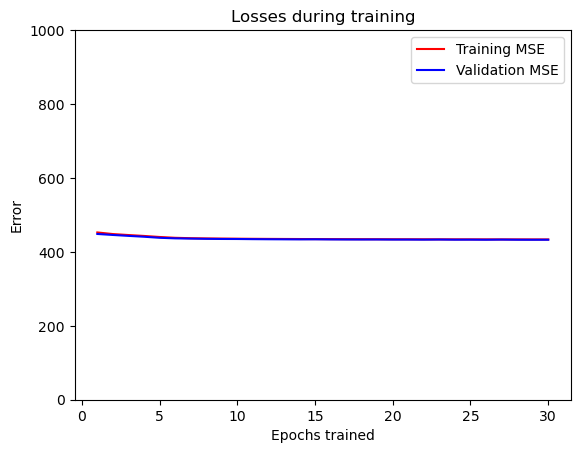

In [22]:
x = range(1, 31)

plt.plot(x, history.history["loss"], color="red", label="Training MSE")

plt.plot(x, history.history["val_loss"], color="blue", label="Validation MSE")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Epochs trained")
plt.ylabel("Error")
plt.ylim((0, 1000))
plt.show()

In [8]:
# keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [24]:
results = model.evaluate(i_test, t_test, batch_size=50)

print("RMSE:", np.sqrt(results[0]))

7680/7680 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step - loss: 428.0926 - mean_absolute_percentage_error: 942605.9375
RMSE: 20.75035297139545
